# Amazon SageMaker Object Detection

1. [Introduction](#Introduction)
2. [Setup AWS CLI](#Setup-AWS-CLI)
3. [Set Project Variables](#Set-Project-Variables)
4. [Data Preparation](#Data-Preparation)
  1. [Shuffle and Split Manifest](#Shuffle-and-Split-Manifest)
  2. [Create Channels](#Create-Channels)
5. [Training](#Initial-Training)
6. [Hosting](#Hosting)
7. [Inference](#Inference)
8. [Preparation for AWS DeepLens](#Preparation-for-AWS-DeepLens)
  1. [Deploy](#Deploy)

## Introduction

This example is based on the https://github.com/aws-samples/amazon-sagemaker-object-detection-from-scratch/blob/master/notebook/finger_counting.ipynb

Labelbox service (https://labelbox.com/) is used instead of AWS GroundTruth Labeling Job as it has a trial period.

SageMaker Studio Lab (https://studiolab.sagemaker.aws/) is recommended for experiments, as it's free of charge.

## Setup AWS CLI

To train the Object Detection algorithm on Amazon SageMaker, we need to setup and authenticate the use of AWS services. To begin with we need an AWS account role with SageMaker access. This role is used to give SageMaker access to your data in S3 will automatically be obtained from the role used to start the notebook.

Install all required libraries and configure AWS CLI. Relevant for SageMaker environment.

!mkdir ~/.aws

%%writefile ~/.aws/credentials

[default]
aws_access_key_id =  AKIA....
aws_secret_access_key = rnq9e+....

%%writefile ~/.aws/config

[default]
region=eu-central-1

## Set Project Variables

In [3]:
bucket = 'deeplens-money-counter-data' #bucker should exist and contain train images
sage_maker_manifest_file_name = 'sg-manifest.manifest' #should exist

manifest_key = 'label/{}'.format(sage_maker_manifest_file_name) #s3://deeplens-money-counter-data/label/sg-manifest.manifest

"""
folder will be created and training and validation manifests will be placed here
"""
s3_artifact_location = 's3://{}/output'.format(bucket)


training_manifest_filename = 'training.manifest' #will be created
validation_manifest_filename = 'validation.manifest' #will be created

training_manifest_key = 'label'
validation_manifest_key = 'label'

- Upload your train images to s3://deeplens-money-counter-data/input/
- Upload sg-manifest.manifest to s3://deeplens-money-counter-data/label/

Model in this project uses images 300x300 size. Probably, larger images can be used also, but it requires EC2 instances with large amount of memory - it's quite expensive. Therefore, let's crop images and re-calculate bounding boxes coordinates.

In [4]:
def visualize_detection(img_file, dets, classes=[], thresh=0.6):
        """
        visualize detections in one image
        visualize_detection('image_92_300x300.jpeg', numpy.array([[0.0, 0.49551838636398315, 0.3853614330291748, 0.12903094291687012, 0.5039911866188049, 0.2453477382659912]]), ['Label'], 0.3)
        Parameters:
        ----------
        img : numpy.array
            image, in bgr format
        dets : numpy.array 
            ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
            each row is one object
        classes : tuple or list of str
            class names
        thresh : float
            score threshold
        """
        import random
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg

        img=mpimg.imread(img_file)
        plt.imshow(img)
        height = img.shape[0]
        width = img.shape[1]
        print('Image size: {}x{}'.format(height, width))
        colors = dict()
        for det in dets:
            (klass, score, x0, y0, x1, y1) = det
            if score < thresh:
                continue
            cls_id = int(klass)
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            xmin = int(x0 * width)
            ymin = int(y0 * height)
            xmax = int(x1 * width)
            ymax = int(y1 * height)
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id],
                                 linewidth=3.5)
            plt.gca().add_patch(rect)
            class_name = str(cls_id)
            if classes and len(classes) > cls_id:
                class_name = classes[cls_id]
            plt.gca().text(xmin, ymin - 2,
                            '{:s} {:.3f}'.format(class_name, score),
                            bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                                    fontsize=12, color='white')
        plt.show()

In [ ]:
%%time
import sagemaker
from sagemaker import get_execution_role

"""
This is the role ARN. Role should have an access to the bucket and its objects, AmazonSageMakerFullAccess,
AWSAppRunnerServicePolicyForECRAccess, and maybe more attached policies.
"""
role = 'arn:aws:iam::<account>:role/service-role/<role name>'
print(role)
sess = sagemaker.Session()

We also need the S3 bucket that you want to use for training and to store the trained model artifacts. In this notebook, we require a custom bucket that exists so as to keep the naming clean. You can end up using a default bucket that SageMaker comes with as well.

Lastly, we need the Amazon SageMaker Object Detection docker image, which is static and need not be changed.

In [8]:
from sagemaker import image_uris
training_image = image_uris.retrieve(framework='object-detection',region=sess.boto_region_name,image_scope='inference',version='latest')
print ('Image: ', training_image)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


Image:  813361260812.dkr.ecr.eu-central-1.amazonaws.com/object-detection:1


## Data Preparation
The current manifest file includes all the data that was labeled by the Labeling Job in GroundTruth or in LabelBox. In order to pass it through the algorithm, we need to shuffle it and split it into training and validation data sets. These data sets are then passed to the SageMaker Estimator as channels.

### Shuffle and Split manifest

In [9]:
%%time
import json
from sklearn.model_selection import train_test_split
import numpy as np
import os
import boto3

s3 = boto3.resource('s3')

manifest = s3.Object(bucket, manifest_key)
#print('Manifest: ', manifest.get()['Body'].read())
items = manifest.get()['Body'].read().decode('utf-8').split('\n')
data = np.array(items)

# Frames without labeled objects should be skipped
numOfElementsBeforeFiltering = len(data)
data = [dataItem for dataItem in data if '"annotations":[]' not in dataItem]
numOfElementsAfterFiltering = len(data)
print('Frames without labels: ', numOfElementsBeforeFiltering - numOfElementsAfterFiltering)
#print('Data: ', data)
# Before splitting, it's good to shuffle the entire dataset.

np.random.shuffle(data)
training_set, validation_set = train_test_split(data, test_size=0.2)

with open(training_manifest_filename, mode='w') as manifest:
    for item in training_set:
        if item:
            manifest.write(item + os.linesep)
    
with open(validation_manifest_filename, mode='w') as manifest:
    for item in validation_set:
        if item:
            manifest.write(item + os.linesep)
        
training_manifest = s3.Object(bucket, training_manifest_key + '/{}'.format(training_manifest_filename))
training_manifest.upload_file(training_manifest_filename)

validation_manifest = s3.Object(bucket, validation_manifest_key + '/{}'.format(validation_manifest_filename))
validation_manifest.upload_file(validation_manifest_filename)

print('Training set: ', len(training_set))
print('Validation set: ', len(validation_set))

Frames without labels:  0
Training set:  207
Validation set:  52
CPU times: user 526 ms, sys: 93.8 ms, total: 619 ms
Wall time: 2.7 s


### Create channels
Let us prepare the handshake between our data channels and the algorithm. To do this, we need to create the `sagemaker.session.s3_input` objects from our data channels. These objects are then put in a simple dictionary, which the algorithm consumes.

In [10]:
def get_object_uri(obj):
    return 's3://{}/{}'.format(obj.bucket_name, obj.key)

print('Training manifest: {}'.format(get_object_uri(training_manifest)))
print('Training manifest: {}'.format(get_object_uri(validation_manifest)))

# Create a train and validation data channel with S3_data_type as 'AugmentedManifestFile' and attribute names.
training_data = sagemaker.inputs.TrainingInput(
                                        get_object_uri(training_manifest),
                                        distribution='FullyReplicated',
                                        content_type='application/x-recordio',
                                        s3_data_type='AugmentedManifestFile',
                                        attribute_names=['source-ref', 'cash'],
                                        record_wrapping='RecordIO') 

print('Training data: ', training_data)
validation_data = sagemaker.inputs.TrainingInput(
                                        get_object_uri(validation_manifest),
                                        distribution='FullyReplicated',
                                        content_type='application/x-recordio',
                                        s3_data_type='AugmentedManifestFile',
                                        attribute_names=['source-ref', 'cash'],
                                        record_wrapping='RecordIO')
print('Validation data: ', validation_data)

data_channels = {'train': training_data, 'validation': validation_data}



Training manifest: s3://deeplens-money-counter-data/label/training.manifest
Training manifest: s3://deeplens-money-counter-data/label/validation.manifest
Training data:  <sagemaker.inputs.TrainingInput object at 0x7f19db05e8b0>
Validation data:  <sagemaker.inputs.TrainingInput object at 0x7f19db05e640>


Next we need to setup an output location at S3, where the model artifact will be dumped. These artifacts are also the output of the algorithm's traning job.

In [11]:
s3_output_location = 's3://{}/output/model'.format(bucket)

print ('Model uri: ', s3_output_location)

Model uri:  s3://deeplens-money-counter-data/output/model


## Training
Now that we are done with all the setup that is needed, we are ready to train our object detector. To begin, let us create a `sagemaker.estimator.Estimator` object. This estimator will launch the training job.

In [12]:
# m5.xlarge is Free tier eligible

od_model = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p3.2xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         input_mode= 'Pipe',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_volume_size has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


The object detection algorithm at its core is the [Single-Shot Multi-Box detection algorithm (SSD)](https://arxiv.org/abs/1512.02325). This algorithm uses a `base_network`, which is typically a [VGG](https://arxiv.org/abs/1409.1556) or a [ResNet](https://arxiv.org/abs/1512.03385). The Amazon SageMaker object detection algorithm supports VGG-16 and ResNet-50 now. It also has a lot of options for hyperparameters that help configure the training job. The next step in our training, is to setup these hyperparameters and data channels for training the model. Consider the following example definition of hyperparameters. See the SageMaker Object Detection [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/object-detection.html) for more details on the hyperparameters.

One of the hyperparameters here for instance is the `epochs`. This defines how many passes of the dataset we iterate over and determines that training time of the algorithm.

Pay attention, that `num_classes` param corresponds to the number of different objects. E.g. we have anly two banknotes: 1000 and 2000 Rub.

In [19]:
training_set_size, validation_set_size = len(training_set), len(validation_set)
print('Training set size: {}'.format(training_set_size))
print('Validation set size: {}'.format(validation_set_size))
print('{} should contain {} records.'.format('s3://' + bucket + '/' + manifest_key, training_set_size + validation_set_size))

Training set size: 207
Validation set size: 52
s3://deeplens-money-counter-data/label/sg-manifest.manifest should contain 259 records.


In [20]:
od_model.set_hyperparameters(base_network='resnet-50',
                             use_pretrained_model=1, #pre-trained models require much less train images
                             num_classes=2, #there are two banknotes 1000 & 2000
                             mini_batch_size=4,
                             epochs=70,
                             learning_rate=0.001,
                             lr_scheduler_step='3,6',
                             lr_scheduler_factor=0.1,
                             optimizer='rmsprop',
                             momentum=0.9,
                             weight_decay=0.0005,
                             overlap_threshold=0.5,
                             nms_threshold=0.45,
                             image_shape=300,
                             label_width=100,
                             num_training_samples=len(training_set))

We have our `Estimator` object, we have set the hyperparameters for this object and we have our data channels linked with the algorithm. The only remaining thing to do is to train the algorithm. The following command will train the algorithm. Training the algorithm involves a few steps. Firstly, the instances that we requested while creating the `Estimator` classes are provisioned and are setup with the appropriate libraries. Then, thanks to using `Pipe` mode, the data from our channels is streamed into the instance and the training begins immediately after the training image is downloaded to the instance and we'll start getting logs. The data logs will also print out Mean Average Precision (mAP) on the validation data, among other losses, for every run of the dataset once or one epoch. This metric is a proxy for the quality of the algorithm.

Once the job has finished a "Training job completed" message will be printed. The trained model can be found in the S3 bucket that was setup as `output_path` in the estimator.

In [ ]:
od_model.fit(inputs=data_channels, logs=True)

## Hosting
Once the training is done, we can deploy the trained model as an Amazon SageMaker real-time hosted endpoint. This will allow us to make predictions (or inference) from the model. Note that we don't have to host on the same instance (or type of instance) that we used to train. Training is a prolonged and compute heavy job that require a different of compute and memory requirements that hosting typically do not. We can choose any type of instance we want to host the model. In our case we chose the `ml.p3.2xlarge` instance to train, but we choose to host the model on the less expensive cpu instance, `ml.m4.xlarge`. The endpoint deployment can be accomplished as follows:

In [ ]:
object_detector = od_model.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.m4.xlarge')

## Inference
Now that the trained model is deployed at an endpoint that is up-and-running, we can use this endpoint for inference. To do this, let us get some random image from the validation data set.

File name:  /tmp/test.jpg


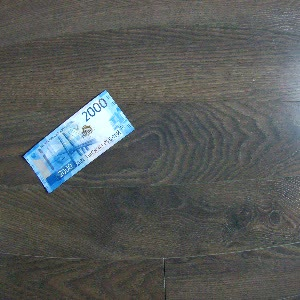

In [53]:
import random
import json

# pic a random image from the validation set
val_image_index = random.randint(0, len(validation_set))
test_img_uri = json.loads(validation_set[val_image_index])['source-ref']

l = test_img_uri[5:].split('/')
bucket = l[0]
key = '/'.join(l[1:])

obj = s3.Object(bucket_name=bucket, key=key)
file_name = '/tmp/test.jpg'

print('File name: ', file_name)
with open(file_name, 'wb') as data:
    obj.download_fileobj(data)
    
# test image
from IPython.display import Image
Image(file_name)

In [31]:
#print('Detector: ', object_detector)
# object_detector.content_type = 'image/jpeg'
results = object_detector.predict(obj.get()['Body'].read(), initial_args={'ContentType': 'image/jpeg'})
detections = json.loads(results)
#print (detections)

The results are in a format that is similar to the .lst format with an addition of a confidence score for each detected object. The format of the output can be represented as `[class_index, confidence_score, xmin, ymin, xmax, ymax]`. Typically, we don't consider low-confidence predictions.

We have provided additional script to easily visualize the detection outputs. You can visualize the high-confidence predictions with bounding box by filtering out low-confidence detections using the script below:

!pip install matplotlib

Image size: 300x300


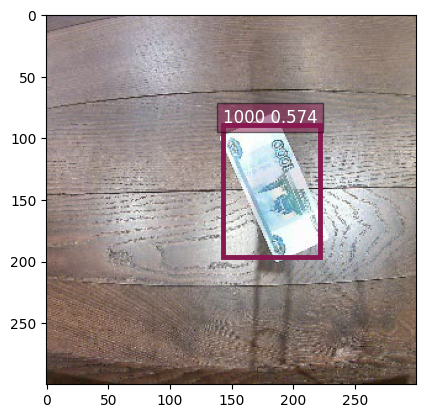

In [32]:
object_categories = ['2000', '1000']

# Setting a threshold 0.20 will only plot detection results that have a confidence score greater than 0.20.
threshold = 0.3

# Visualize the detections.
visualize_detection(file_name, detections['prediction'], object_categories, threshold)

# Preparation for AWS DeepLens
DeepLens requires some previous manipulation of the model in order to work. For this we need the model artifact and the MXNet deploy script.

In [54]:
print(od_model.model_data)
# Download the model artifact
!aws s3 cp '{od_model.model_data}' .

s3://deeplens-money-counter-data/output/model/object-detection-2022-10-30-20-09-41-613/output/model.tar.gz
download: s3://deeplens-money-counter-data/output/model/object-detection-2022-10-30-20-09-41-613/output/model.tar.gz to ./model.tar.gz


In [55]:
# Extract the contents and rename it for the deployment script
!mkdir -p model
!tar -xvzf model.tar.gz -C model
!mv model/model_algo_1-0000.params model/ssd_resnet50_300-0000.params
!mv model/model_algo_1-symbol.json model/ssd_resnet50_300-symbol.json

hyperparams.json
model_algo_1-symbol.json
model_algo_1-0000.params


# Older version is required! Use incubator provided with this notebook instead of cloning repository
# Download the script from GitHub
!git clone https://github.com/apache/incubator-mxnet

In [ ]:
# Required for incubator
!pip install mxnet

In [56]:
# Run the script with the right parameters
!python incubator-mxnet/example/ssd/deploy.py --network resnet50 --num-class 2

[20:27:03] ../src/nnvm/legacy_json_util.cc:208: Loading symbol saved by previous version v1.4.1. Attempting to upgrade...
[20:27:03] ../src/nnvm/legacy_json_util.cc:216: Symbol successfully upgraded!
Saved model: /home/studio-lab-user/deeplens-money-counter/notebook/model/deploy_ssd_resnet50_300-0000.params
Saved symbol: /home/studio-lab-user/deeplens-money-counter/notebook/model/deploy_ssd_resnet50_300-symbol.json


In [57]:
# Zip the deployable model and copy it to the DeepLens bucket
!tar -cvzf patched_model.tar.gz -C model \
./deploy_ssd_resnet50_300-0000.params \
./deploy_ssd_resnet50_300-symbol.json \
./hyperparams.json

./deploy_ssd_resnet50_300-0000.params
./deploy_ssd_resnet50_300-symbol.json
./hyperparams.json


In [58]:
# Copy the patched model to the DeepLens bucket
deeplens_bucket = 'deeplens-money-counter-data'
!aws s3 cp patched_model.tar.gz s3://{deeplens_bucket}/model/

upload: ./patched_model.tar.gz to s3://deeplens-money-counter-data/model/patched_model.tar.gz


# Deploy

Go to the DeepLens Console and create a project, import an external model using the S3 Uri for the patched_model.tar.gz, then deploy it to the device.

## Delete the Endpoint
Having an endpoint running will incur some costs. Therefore as a clean-up job, we should delete the endpoint.

In [ ]:
sagemaker.Session().delete_endpoint(object_detector.endpoint)